In [35]:
import configparser
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd

from scipy import stats
import seaborn as sns
import subprocess
import sys

# Import relevant libraries for HTTP request and JSON formatting
import requests
import json

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_")
import config_readwrite as crw
import fet
import plot_params as pp
import opentarget as otg

pd.set_option('display.max_rows', 25)

# Functions

## gene target query

In [2]:
def query_OpenTargetGenetics_genesForVariant(variant_id):
    
    # Build query string
    query_string = """
    query genesForVariant ($myVariantId: String!){
      genesForVariant(variantId:$myVariantId) {
        gene {
            id
            symbol
            description
            }
        variant
        overallScore
        qtls {
            typeId
            sourceId
            aggregatedScore
            tissues {
                tissue {
                    id
                    name
                    }
                }
                
            }
        distances {
        tissues { distance
        }
        }
        
    }
}
    """ 

    # Set variables object of arguments to be passed to endpoint
    variables = { "myVariantId": variant_id}

    # Set base URL of Genetics Portal GraphQL API endpoint
    base_url = "https://api.genetics.opentargets.org/graphql"

    # Perform POST request and check status code of response
    r = requests.post(base_url, json={"query": query_string, "variables": variables})
    #print(r.status_code)

    # Transform API response into JSON 
    api_response_as_json = json.loads(r.text)
    return api_response_as_json
    """
    # Length of the results 
    #print(api_response_as_json)
    #res_len = len(api_response_as_json["data"]["genesForVariant"]["gene".values()])

    # Return results or flag of no results
    #if res_len >0:
        
        # Print first element of JSON response data
        #print(api_response_as_json["data"]["pheWAS"]["associations"][0])
        
        # Return results
        return api_response_as_json
    
    else:
        # Flag no results
        
        #print("no results")
        
        # Return None
        return None
    """

## query gene to dict

In [3]:
def gene_outputs_todict(query_results):
    
    """
    parse the open target results for one single variant. 
    
    1 - make dictionary to collect results
    2 - per key (field/measurement), add value to list of values
    3 - if key is the study object, the study object is a dictionary and we have to parse this separately
        3a - if study information is None, rename j,k variables as key = None, value = empty_dict
    4 - if key is not already in dictionary, create key w empty list, append value to list, then reassign dictionary key w/ value list
    5 - if key is in dictionary, append value to list, then reassign dictionary key w/ value list
    
    """
    
    #1
    results_dict = {}
    
    #2
    for i in query_results["data"]["genesForVariant"]["gene"]:    
        for key, val in i.items():
            
            #3
            if type(key) == dict:
                
                #3a
                if val == None:
                    continue
                    
                for j,k in val.items():
                    
                    #4
                    if j not in results_dict.keys():
                        results_dict[j] = []
                        results_list = results_dict[j]
                        results_list.append(k)
                        results_dict[j] = results_list
                    #5
                    else:
                        results_list = results_dict[j]
                        results_list.append(k)
                        results_dict[j] = results_list

            else:
                
                #4
                if key not in results_dict.keys():
                    results_dict[key] = []
                    results_list = results_dict[key]
                    results_list.append(val)
                    results_dict[key] = results_list
                #5
                else:
                    results_list = results_dict[key]
                    results_list.append(val)
                    results_dict[key] = results_list
    return results_dict

In [4]:
def plot_phewas_hits(df):

    print(df[["pval", "var_id", "traitReported"]].sort_values(by = "pval").shape, df[["pval", "var_id", "traitReported"]].sort_values(by = "pval").drop_duplicates().shape)

    trait_counts = df[["var_id", "traitReported"]].drop_duplicates().groupby("traitReported")['var_id'].count().reset_index()

    x = "var_id"
    y = "traitReported"
    data = trait_counts.loc[trait_counts.var_id >20].sort_values(by = "var_id")
    fig, ax = plt.subplots(figsize = (6, 18))
    sns.barplot(x=x,y=y,data=data)
    plt.show()

# download the open target variant index files. 

##  analysis configuration file load

In [5]:
nameA = os.path.join("/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/SF_hu-rhe/main_thirdrep/analyses/" "config_analyses")
configA, configA_name = crw.read_config(nameA)

In [6]:
HUACC = configA["HUMAN_ACC"]["huacc-10"]
OUT = configA["OPEN_TARGET"]["huacc-10"]
RE = configA["OPEN_TARGET"]["path"]
DORS_PATH = configA["OPEN_TARGET"]["dors_path"]

HH = configA["ACTIVITY_SHAREDACC"]["activity_df_HH"]
OTG_HH_VAR = configA["OPEN_TARGET"]["HH"] # HH intersected w/ open target variants

In [7]:
name = os.path.join("/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/fantom", "config")
config, config_name = crw.read_config(name)

DIFEXP = config["RNASEQ"]["dif_exp"]

## load open target pheWAS data for HH 

In [8]:
OTGS = glob.glob(os.path.join(RE, "otg_HH_*.tsv"))

otg_results = {}

for otf in OTGS:
    key = (otf.split("otg_HH")[1]).split(".tsv")[0]
    val = pd.read_csv(otf, sep='\t')
    otg_results[key]= val

### concat all pheWAS data

In [9]:
df = pd.concat(otg_results.values())

print(df.shape)
df.head()

(617094, 14)


,studyId,eaf,beta,se,nTotal,nCases,oddsRatio,pval,traitCategory,traitEfos,traitReported,numAssocLoci,var_id,activity_code
0,GCST90002406,0.264234,-0.015895,0.002423,408112,NaN,NaN,5.400000e-11,measurement,['EFO_0010700'],Reticulocyte fraction of red cells,725.0,1_3857566_A_G,1101
1,NEALE2_23125_raw,0.264106,0.004030,0.001265,354668,NaN,NaN,1.444370e-03,measurement,['EFO_0004995'],Arm fat-free mass (left),649.0,1_3857566_A_G,1101
2,FINNGEN_R5_Q17_CONGEN_MALFO_EYE_EAR_FACE_NECK,0.278200,0.145300,0.050500,218792,1007.0,1.156386,4.016000e-03,"genetic, familial or congenital disease",['MONDO_0007500'],"""Congenital malformations of eye, ear, face an...",0.0,1_3857566_A_G,1101
3,NEALE2_20002_1385,0.264156,0.119691,0.039950,361141,1621.0,1.127148,2.734890e-03,immune system disease,['EFO_1001890'],Allergy or anaphylactic reaction to food | non...,1.0,1_3857566_A_G,1101
4,GCST004628,0.266300,-0.016719,0.004039,170548,NaN,NaN,3.478000e-05,measurement,['EFO_0007986'],Immature fraction of reticulocytes,182.0,1_3857566_A_G,1101


## load open target variant overlap in HH data.

In [10]:
usecols = ['#chr',
 'start',
 'end',
 'bin',
 'activity_code',
 'position',
    "var"]
hhvar = pd.read_csv(OTG_HH_VAR, sep = '\t', usecols = usecols).drop_duplicates()

print(hhvar.shape)
hhvar.head()

(179020, 7)


,#chr,start,end,bin,activity_code,position,var
0,chr1,958994,959044,bin_1256,1000,959027,1_959027_C_T
1,chr1,959064,959114,bin_1263,1000,959108,1_959108_G_T
2,chr1,959074,959124,bin_1264,1000,959108,1_959108_G_T
3,chr1,959084,959134,bin_1265,1000,959108,1_959108_G_T
4,chr1,959094,959144,bin_1266,1000,959108,1_959108_G_T


## load human acceleration data. 
- phyloP < -1 for short or long term

In [11]:
huacc= pd.read_csv(HUACC, sep = '\t')
huacc.head()

,#chr,start,end,bin,activity_code,br-hg38.mod-full,br-hg38.mod-hg38,cons_act,Null_0000,cis_only,trans_only,hu_cis_and_trans
0,chr1,6414542,6414592,bin_31326,1100,-1.463,-0.583,False,False,True,False,False
1,chr1,9825616,9825666,bin_53261,1000,-1.146,-0.095,False,False,False,False,True
2,chr1,9825626,9825676,bin_53262,1000,-1.104,-0.073,False,False,False,False,True
3,chr1,12161641,12161691,bin_68433,1100,-1.100,0.212,False,False,True,False,False
4,chr1,12163091,12163141,bin_68578,1000,-1.368,0.299,False,False,False,False,True


In [12]:
huacc.loc[(huacc["br-hg38.mod-full"]< -2.7) & (huacc["activity_code"]==1100)]

,#chr,start,end,bin,activity_code,br-hg38.mod-full,br-hg38.mod-hg38,cons_act,Null_0000,cis_only,trans_only,hu_cis_and_trans
524,chr10,110414610,110414660,bin_1119114,1100,-3.111,-0.964,False,False,True,False,False
525,chr10,110414620,110414670,bin_1119115,1100,-3.012,-0.872,False,False,True,False,False
962,chr12,122266371,122266421,bin_1970960,1100,-3.013,-2.040,False,False,True,False,False
1400,chr17,5486761,5486811,bin_3102160,1100,-2.899,-0.581,False,False,True,False,False
1740,chr2,113890965,113891015,bin_4364688,1100,-2.725,0.693,False,False,True,False,False
1752,chr2,128091005,128091055,bin_4384950,1100,-2.981,0.059,False,False,True,False,False
1753,chr2,128091015,128091065,bin_4384951,1100,-3.588,0.070,False,False,True,False,False
1754,chr2,128091025,128091075,bin_4384952,1100,-2.979,-0.020,False,False,True,False,False
3142,chr8,66666748,66666798,bin_7557817,1100,-2.744,-2.581,False,False,True,False,False


In [13]:
huacc.loc[(huacc['bin'].str.contains("bin_310216"))]

,#chr,start,end,bin,activity_code,br-hg38.mod-full,br-hg38.mod-hg38,cons_act,Null_0000,cis_only,trans_only,hu_cis_and_trans
1400,chr17,5486761,5486811,bin_3102160,1100,-2.899,-0.581,False,False,True,False,False
1401,chr17,5486771,5486821,bin_3102161,1100,-1.411,-0.103,False,False,True,False,False


In [14]:
huacc.loc[(huacc['bin'].str.contains("bin_310215"))]

,#chr,start,end,bin,activity_code,br-hg38.mod-full,br-hg38.mod-hg38,cons_act,Null_0000,cis_only,trans_only,hu_cis_and_trans
1396,chr17,5486721,5486771,bin_3102156,1000,-1.240,-0.429,False,False,False,False,True
1397,chr17,5486731,5486781,bin_3102157,1000,-2.038,-0.489,False,False,False,False,True
1398,chr17,5486741,5486791,bin_3102158,1100,-2.008,-0.898,False,False,True,False,False
1399,chr17,5486751,5486801,bin_3102159,1100,-1.943,-0.221,False,False,True,False,False


## combine it all together

In [15]:
merged = pd.merge(hhvar, huacc, how = "left")
merged.shape

(179020, 14)

#  query Cis, trans, cis_and_trans variants

In [16]:
query_cols = ["cis_only", "trans_only", "hu_cis_and_trans", "cons_act"]

otg = {}
AS = {}


for query_col in query_cols:

    test1 = merged.loc[(merged[query_col]==True) & (merged["br-hg38.mod-full"]<-1)]
    test2 = merged.loc[(merged[query_col]==True) & (merged["br-hg38.mod-hg38"]<-1)]
    test = pd.concat([test1, test2]).drop_duplicates()
    
    bins = set(test["var"])
    
    pheWAS = df.loc[df["var_id"].isin(bins)]
    
    otg[query_col] = pheWAS
    AS[query_col]=test

otg.keys()

dict_keys(['cis_only', 'trans_only', 'hu_cis_and_trans', 'cons_act'])

In [17]:
"""
for key, val in otg.items():
    df = val
    print(df[["pval", "var_id", "traitReported"]].sort_values(by = "pval").shape, df[["pval", "var_id", "traitReported"]].sort_values(by = "pval").drop_duplicates().shape)

    trait_counts = df[["var_id", "traitReported"]].drop_duplicates().groupby("traitReported")['var_id'].count().reset_index()

    x = "var_id"
    y = "traitReported"
    data = trait_counts.loc[trait_counts.var_id >10].sort_values(by = "var_id")
    fig, ax = plt.subplots(figsize = (6, 18))
    sns.barplot(x=x,y=y,data=data)
    ax.set(title = key)
"""

'\nfor key, val in otg.items():\n    df = val\n    print(df[["pval", "var_id", "traitReported"]].sort_values(by = "pval").shape, df[["pval", "var_id", "traitReported"]].sort_values(by = "pval").drop_duplicates().shape)\n\n    trait_counts = df[["var_id", "traitReported"]].drop_duplicates().groupby("traitReported")[\'var_id\'].count().reset_index()\n\n    x = "var_id"\n    y = "traitReported"\n    data = trait_counts.loc[trait_counts.var_id >10].sort_values(by = "var_id")\n    fig, ax = plt.subplots(figsize = (6, 18))\n    sns.barplot(x=x,y=y,data=data)\n    ax.set(title = key)\n'

# Look at Cis-only data

In [18]:
key = "cis_only"
df = otg[key]
dfas = AS[key]

df.head()

,studyId,eaf,beta,se,nTotal,nCases,oddsRatio,pval,traitCategory,traitEfos,traitReported,numAssocLoci,var_id,activity_code
5070,FINNGEN_R5_O15_PREG_BIRTH_PUERP,0.006145,-0.1595,0.0567,123579,80417.0,0.852570,0.004890,pregnancy or perinatal disease,"['EFO_0002950', 'EFO_0009683']","""Pregnancy, childbirth and the puerperium""",0.0,1_234926685_C_T,1101
5071,FINNGEN_R5_M13_SOFTTISSUE,0.006036,-0.1499,0.0508,218792,51151.0,0.860794,0.003185,Uncategorised,['EFO_0009470'],Soft tissue disorders,6.0,1_234926685_C_T,1101
5072,FINNGEN_R5_K11_IMPACTED_TEETH,0.006036,-0.9485,0.3309,218792,884.0,0.387322,0.004147,phenotype,['HP_0011079'],Impacted teeth,1.0,1_234926685_C_T,1101
5073,FINNGEN_R5_J10_ACUTELOWERNAS,0.006001,-0.6097,0.2012,210961,2272.0,0.543514,0.002438,infectious disease,['MONDO_0024355'],Unspecified acute lower respiratory infection,0.0,1_234926685_C_T,1101
5074,FINNGEN_R5_CD2_INSITU_SKIN,0.006036,-0.7164,0.2488,218792,1379.0,0.488508,0.003980,cell proliferation disorder,['MONDO_0004641'],Carcinoma in situ of skin,4.0,1_234926685_C_T,1101


## bonferroni correction

In [19]:
bonferroni = 0.05/df.shape[0] # bonferroni cut off

df["bonferroni"] = False  # make a boolean column
df.loc[df["pval"] <bonferroni, "bonferroni"] = True

bdf = df.loc[df["bonferroni"] == True]
print("n bonferroni significant variants in", key, len(bdf.var_id.unique()))
bdf.head()

n bonferroni significant variants in cis_only 53


,studyId,eaf,beta,se,nTotal,nCases,oddsRatio,pval,traitCategory,traitEfos,traitReported,numAssocLoci,var_id,activity_code,bonferroni
40432,GCST90002401,0.541710,0.010629,0.002161,408112,NaN,NaN,8.700000e-07,measurement,['EFO_0007984'],Platelet distribution width,741.0,6_157562142_A_G,1101,True
6502,NEALE2_5375_raw,0.000279,56.345300,10.689400,32165,NaN,NaN,1.364640e-07,measurement,['EFO_0007803'],Longest period of unenthusiasm / disinterest,22.0,1_32180491_G_A,1000,True
27911,GCST90002401,0.642950,0.014319,0.002231,408112,NaN,NaN,1.400000e-10,measurement,['EFO_0007984'],Platelet distribution width,741.0,1_236604526_T_C,1000,True
27920,GCST90002357,0.639409,-0.015276,0.001898,542827,NaN,NaN,8.840000e-16,measurement,['EFO_0004309'],Platelet count,1252.0,1_236604526_T_C,1000,True
27935,GCST90002400,0.642954,-0.015341,0.002202,408112,NaN,NaN,3.300000e-12,measurement,['EFO_0007985'],Plateletcrit,952.0,1_236604526_T_C,1000,True


## human acc scores x bonferroni variants

In [20]:
bdfHUACC = pd.merge(bdf, dfas, how="left", left_on = "var_id", right_on = "var")

## long term acceleration

- 3_53882103_A_G:
    - Viral infections of the central nervous system, 
    - ACTR8, IL17RB (INFLAMMATORY RECEPTOR) 
    - https://genetics.opentargets.org/variant/3_53882103_A_G
    - ancestral = G, https://uswest.ensembl.org/Homo_sapiens/Variation/Explore?r=3:53881603-53882603;v=rs2276845;vdb=variation;vf=91856120
    
- 5_132103643_A_T: 
    - eosinophil count 
    - 29kb CSF2 (CYTOKINE) - https://www.uniprot.org/uniprot/P04141
    - 91kb ASCL6 - long chain fatty acid synthesis in brain - https://www.uniprot.org/uniprot/Q9UKU0
    - https://genetics.opentargets.org/variant/5_132103643_A_T

- 18_3449288_G_C
    - monocyte count
    - 38kb - TGIF1 (TRANSCRIPTION FACTOR) BINDS RXR-alpha motifs - https://www.uniprot.org/uniprot/Q15583
    - rs238134,  
    - https://genetics.opentargets.org/variant/18_3449288_G_C
- 12_31729274_G_A: 
    - Lymphocyte counts 
    - AMN1, RESF1 (PC-HiC, eQTL)
    - https://genetics.opentargets.org/variant/12_31729274_G_A
- 17_73193043_A_G
    - RBC/ mean corpuscular volume
    - COG1 TSS
    - 44 kb FAM104A (PC-HiC, eQTL) (not sure of function) - https://www.uniprot.org/uniprot/Q969W3
- 1_26112007_G_C 
    - standing height, body mass, 
    - (900bp) PDIK1l, CD52 (PC-HiC + eQTL)
    
- 9_113275614_C_T
    - corneal hysteris, WBC count, neutrophil count, body fat
    - (28bp) PRPF4 - U4/U6 splicing - https://www.uniprot.org/uniprot/O43172
- 6_152302397_C_T
    - Leiomyoma of uterus, benign neoplasms
    - rs1408459
    - SYNE1 - for nuclear lamina organization - https://www.uniprot.org/uniprot/Q8NF91
    - ZBTB2 - transcriptional regulation - https://www.uniprot.org/uniprot/Q8N680
        - C2H2 bindingn domains
        
- 11_67607110_T_C
    - mean corpuscular, reticulocyte, corpuscular hemoglobin volume
    - NDUFV1
    - https://genetics.opentargets.org/variant/11_67607110_T_C
- 1_236604526_T_C
    - HEATR1

In [21]:
cols = ["traitReported", "var", 'oddsRatio',
 'pval',"br-hg38.mod-full", "br-hg38.mod-hg38"]

huacc_col = "br-hg38.mod-hg38"
bdfHUACC[cols].loc[bdfHUACC[huacc_col]<-1].sort_values(by = huacc_col).drop_duplicates()["var"].unique()

array(['3_53882103_A_G', '5_132103643_A_T', '18_3449288_G_C',
       '17_73193043_A_G', '1_26112007_G_C', '9_113275614_C_T',
       '22_45235284_T_C', '1_40509127_T_C', '6_152302397_C_T',
       '11_67607110_T_C', '3_33798607_G_A', '3_33798622_T_C',
       '1_236604526_T_C', '2_73214385_C_T', '5_140557561_G_A',
       '1_26111964_T_C', '12_31729274_G_A', '3_50321821_G_T',
       '3_50321815_AGGG_A'], dtype=object)

In [22]:
cols = ["traitReported", "var", 'oddsRatio',
 'pval',"br-hg38.mod-full", "br-hg38.mod-hg38"]

huacc_col = "br-hg38.mod-full"
bdfHUACC[cols].loc[bdfHUACC[huacc_col]<-1].sort_values(by = huacc_col).drop_duplicates()["var"].unique()

array(['17_5486808_A_G', '3_57597538_A_T', '1_236604526_T_C',
       '19_29213257_T_C', '6_152302397_C_T', '18_3449288_G_C',
       '17_5486742_A_T', '2_86195298_T_G', '9_128067285_C_T',
       '9_273145_TTG_T', '12_27208102_T_A', '12_27208100_C_A',
       '17_81513660_T_C', '3_53882103_A_G', '1_32180491_G_A',
       '6_44073155_G_C', '9_94259340_TGC_T', '11_65638708_C_A',
       '9_123339601_G_A', '6_157562142_A_G', '7_127392526_A_G',
       '7_127392545_A_C', '3_57597485_G_A', '14_102754493_A_C',
       '14_102754509_A_C', '1_26112007_G_C', '1_26111964_T_C',
       '2_42102189_A_G', '11_67607110_T_C', '17_30340576_G_A',
       '17_30340561_T_C', '16_71895327_C_T', '19_29213103_A_C',
       '19_29213095_T_C', '5_158560181_G_A', '1_169486197_G_C',
       '1_12161664_C_T', '1_31889579_T_C', '15_63833957_C_T',
       '3_12187460_CTCTTCCTCCTCT_C', '3_33798622_T_C', '2_218710704_G_C'],
      dtype=object)

## short term acceleration 

In [23]:
cols = ["traitReported", "var", 'oddsRatio',
 'pval',"br-hg38.mod-full", "br-hg38.mod-hg38"]

huacc_col = "br-hg38.mod-full"
bdfHUACC[cols].loc[bdfHUACC[huacc_col]<-1].sort_values(by = huacc_col).drop_duplicates()

,traitReported,var,oddsRatio,pval,br-hg38.mod-full,br-hg38.mod-hg38
518,Platelet count,17_5486808_A_G,NaN,8.540000e-11,-2.899,-0.581
512,Platelet count,17_5486808_A_G,NaN,3.000000e-07,-2.899,-0.581
528,White blood cell count,17_5486808_A_G,NaN,9.780000e-09,-2.899,-0.581
520,Lymphocyte counts,17_5486808_A_G,NaN,9.100000e-08,-2.899,-0.581
526,Mean platelet (thrombocyte) volume,17_5486808_A_G,NaN,1.396910e-06,-2.899,-0.581
...,...,...,...,...,...,...
671,Appendicular lean mass,2_218710704_G_C,NaN,1.010000e-07,-1.014,1.141
822,Leiomyoma of uterus (all cancers excluded),6_152302397_C_T,1.111933,1.372000e-11,-1.013,-0.343
816,Heel bone mineral density,6_152302397_C_T,NaN,3.100000e-06,-1.013,-0.343
818,Leiomyoma of uterus,6_152302397_C_T,1.108713,7.266000e-12,-1.013,-0.343


## nearby variant pairs do not have same traits.  
- two variants, 2 bp apart
- both pass bonferroni correction

In [24]:
LD_pair = [ '12_27208100_C_A', '12_27208102_T_A']
bdf.loc[bdf["var_id"].isin(LD_pair)] 

,studyId,eaf,beta,se,nTotal,nCases,oddsRatio,pval,traitCategory,traitEfos,traitReported,numAssocLoci,var_id,activity_code,bonferroni
13498,NEALE2_102_raw,0.533167,-0.127628,0.027281,340162,NaN,NaN,0.000003,measurement,['EFO_0008111'],"Pulse rate, automated reading",290.0,12_27208100_C_A,1100,True
13564,SAIGE_535,0.058900,0.087300,0.018900,407065,28941.0,1.091224,0.000004,gastrointestinal disease,['EFO_0000217'],Gastritis and duodenitis,1.0,12_27208102_T_A,1100,True


## two variants, 16 bp apart, overlap platelet count, but annotations are not identical

In [25]:
LD_pair = ['14_102754493_A_C', '14_102754509_A_C']
bdf.loc[bdf["var_id"].isin(LD_pair)] 

,studyId,eaf,beta,se,nTotal,nCases,oddsRatio,pval,traitCategory,traitEfos,traitReported,numAssocLoci,var_id,activity_code,bonferroni
21016,GCST90002346,0.018321,0.035958,0.007163,460935,NaN,NaN,5.270000e-07,measurement,['EFO_0004584'],Mean platelet volume,1037.0,14_102754493_A_C,1100,True
21021,GCST90002402,0.018350,-0.049864,0.007867,408112,NaN,NaN,2.300000e-10,measurement,['EFO_0004309'],Platelet count,989.0,14_102754493_A_C,1100,True
21035,NEALE2_30080_raw,0.018472,-2.844680,0.514035,350474,NaN,NaN,3.132100e-08,measurement,['EFO_0004309'],Platelet count,693.0,14_102754493_A_C,1100,True
21037,GCST90002357,0.018103,-0.046660,0.006928,542827,NaN,NaN,1.700000e-11,measurement,['EFO_0004309'],Platelet count,1252.0,14_102754493_A_C,1100,True
21039,NEALE2_30100_raw,0.018472,0.047933,0.009546,350470,NaN,NaN,5.131060e-07,measurement,['EFO_0004584'],Mean platelet (thrombocyte) volume,726.0,14_102754493_A_C,1100,True
21054,GCST90002395,0.018351,0.036887,0.007650,408112,NaN,NaN,1.400000e-06,measurement,['EFO_0004584'],Mean platelet volume,992.0,14_102754493_A_C,1100,True
21071,GCST90002400,0.018356,-0.038085,0.007921,408112,NaN,NaN,1.500000e-06,measurement,['EFO_0007985'],Plateletcrit,952.0,14_102754493_A_C,1100,True
21091,GCST90002357,0.007287,-0.059617,0.011823,542827,NaN,NaN,4.690000e-07,measurement,['EFO_0004309'],Platelet count,1252.0,14_102754509_A_C,1100,True
21093,GCST90002402,0.007377,-0.064797,0.013500,408112,NaN,NaN,1.600000e-06,measurement,['EFO_0004309'],Platelet count,989.0,14_102754509_A_C,1100,True
5178,GCST90002357,0.007287,-0.059617,0.011823,542827,NaN,NaN,4.690000e-07,measurement,['EFO_0004309'],Platelet count,1252.0,14_102754509_A_C,1110,True


[Text(0.5, 1.0, 'cis_only, human accelerated'),
 Text(0.5, 0, 'n significant variants (bonferroni-corrected)')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


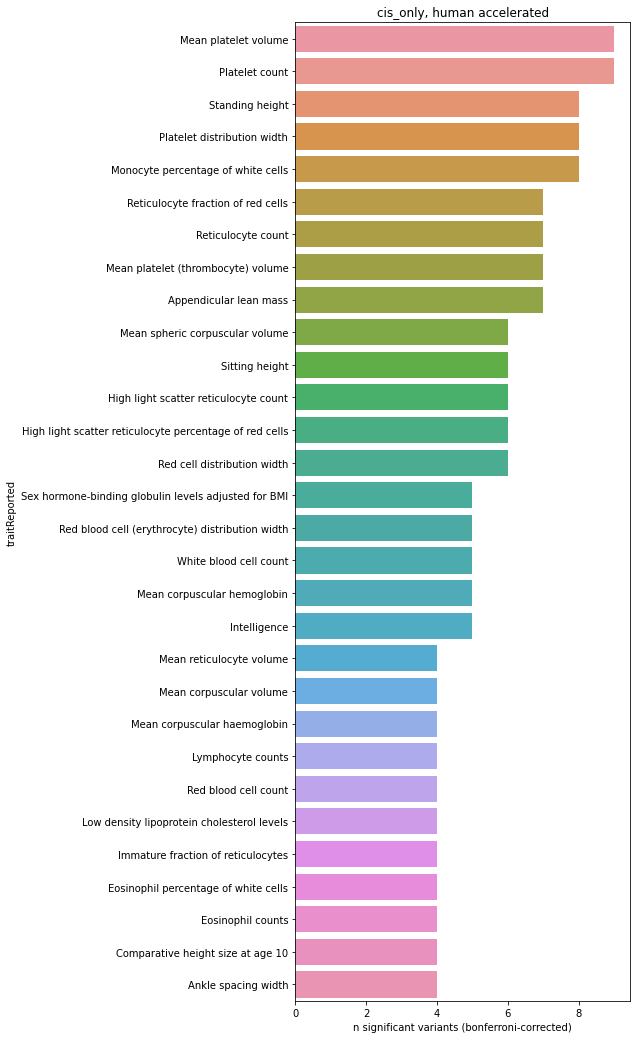

In [26]:
trait_counts = bdf[["var_id", "traitReported", "bonferroni"]].drop_duplicates().groupby(["traitReported", "bonferroni"])['var_id'].count().reset_index()

x = "var_id"
y = "traitReported"
data = trait_counts.loc[trait_counts.var_id >3].sort_values(by = "var_id", ascending = False)
fig, ax = plt.subplots(figsize = (6, 18))
sns.barplot(x=x,y=y,data=data)
ax.set(title = "cis_only, human accelerated", xlabel = "n significant variants (bonferroni-corrected)")

# 17_5486808_A_G & NLRP1

In [27]:
bdfHUACC.loc[bdfHUACC['var']=="17_5486808_A_G"].sort_values(by="bin")["traitReported"].unique()

array(['Platelet count', 'Mean platelet (thrombocyte) volume',
       'Mean platelet volume', 'White blood cell count',
       'Lymphocyte counts'], dtype=object)

## Query gene expression of linked genes

In [28]:
ID = "17_5486808_A_G"

## get genes linked to variant

In [37]:
ID

'17_5486808_A_G'

In [38]:
otg.get_genes_per_var(ID)

(['RNF167',
  'USP6',
  'DERL2',
  'NLRP1',
  'DHX33',
  'SCIMP',
  'ZNF232',
  'SLC52A1',
  'RPAIN',
  'RABEP1',
  'INCA1',
  'PIMREG',
  'CAMTA2',
  'TXNDC17',
  'KIAA0753',
  'C1QBP',
  'KIF1C',
  'NUP88',
  'ZNF594',
  'ZFP3',
  'MIS12',
  'AIPL1'],
 ['RNF167', 'NLRP1', 'SCIMP', 'RABEP1', 'CAMTA2', 'NUP88', 'MIS12'],
 ['USP6',
  'DERL2',
  'NLRP1',
  'DHX33',
  'SCIMP',
  'ZNF232',
  'SLC52A1',
  'RPAIN',
  'RABEP1',
  'INCA1',
  'CAMTA2',
  'C1QBP',
  'KIF1C',
  'NUP88',
  'ZNF594',
  'ZFP3',
  'MIS12'])

In [39]:
genes, eqtl_genes, megabase = otg.get_genes_per_var(ID)

## genes outside 500kb around variant

In [40]:
genes, eqtl_genes, megabase

(['RNF167',
  'USP6',
  'DERL2',
  'NLRP1',
  'DHX33',
  'SCIMP',
  'ZNF232',
  'SLC52A1',
  'RPAIN',
  'RABEP1',
  'INCA1',
  'PIMREG',
  'CAMTA2',
  'TXNDC17',
  'KIAA0753',
  'C1QBP',
  'KIF1C',
  'NUP88',
  'ZNF594',
  'ZFP3',
  'MIS12',
  'AIPL1'],
 ['RNF167', 'NLRP1', 'SCIMP', 'RABEP1', 'CAMTA2', 'NUP88', 'MIS12'],
 ['USP6',
  'DERL2',
  'NLRP1',
  'DHX33',
  'SCIMP',
  'ZNF232',
  'SLC52A1',
  'RPAIN',
  'RABEP1',
  'INCA1',
  'CAMTA2',
  'C1QBP',
  'KIF1C',
  'NUP88',
  'ZNF594',
  'ZFP3',
  'MIS12'])

## differential expression of linked genes

In [41]:
rnaseq = pd.read_csv(DIFEXP, sep = '\t')
rnaseq.head()

,ENSEMBL,SYMBOL,baseMean,log2FoldChange,lfcSE,pvalue,padj
0,ENSG00000101557,USP14,2058.430757,0.044756,0.083888,0.593409,0.660446
1,ENSG00000079134,THOC1,3652.802897,0.353213,0.074687,0.000002,0.000006
2,ENSG00000158270,COLEC12,1.192315,-0.034586,0.964963,0.911987,0.932622
3,ENSG00000079101,CLUL1,1.642457,-0.348055,1.029846,0.342998,0.422974
4,ENSG00000176912,TYMSOS,32.727864,-1.035884,0.476578,0.014382,0.025390


In [42]:
rna = rnaseq.loc[rnaseq["SYMBOL"].isin(genes)]

rna["reject_null"] = False

rna.loc[rna["padj"]<0.05, "reject_null"] =True

rna["-log10p"] = np.log10(rna["padj"])*-1

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fongsl/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [43]:
rna.sort_values(by ="log2FoldChange" )

,ENSEMBL,SYMBOL,baseMean,log2FoldChange,lfcSE,pvalue,padj,reject_null,-log10p
12689,ENSG00000180626,ZNF594,48.830008,-3.517142,0.527172,5.221149e-12,2.466328e-11,True,10.607949
12696,ENSG00000091592,NLRP1,191.972401,-2.921673,0.251016,4.648182e-32,5.461361e-31,True,30.262699
12693,ENSG00000129197,RPAIN,368.449538,-1.755483,0.165714,9.204701e-27,9.024500e-26,True,25.044577
12690,ENSG00000161929,SCIMP,165.023694,-1.495790,0.234761,6.528537e-11,2.853004e-10,True,9.544698
12679,ENSG00000108523,RNF167,419.996423,-0.659136,0.151333,1.028538e-05,2.805826e-05,True,4.551939
12692,ENSG00000108559,NUP88,1385.722053,-0.451834,0.094335,1.481838e-06,4.448529e-06,True,5.351784
12694,ENSG00000005100,DHX33,571.673963,-0.340885,0.131961,9.143235e-03,1.672772e-02,True,1.776563
12691,ENSG00000029725,RABEP1,4627.010212,-0.336604,0.086196,8.871908e-05,2.175870e-04,True,3.662367
12683,ENSG00000196388,INCA1,17.325319,-0.188434,0.545439,6.816838e-01,7.374985e-01,False,0.132239
12695,ENSG00000072849,DERL2,779.052681,-0.035519,0.117684,7.603930e-01,8.065723e-01,False,0.093357


/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 RNF167 0.6591356496892514
1 CAMTA2 -0.571721258964838
2 SCIMP 1.4957899185876724
3 RABEP1 0.3366042616418769
4 NUP88 0.45183447893343504
5 NLRP1 2.9216729151500167


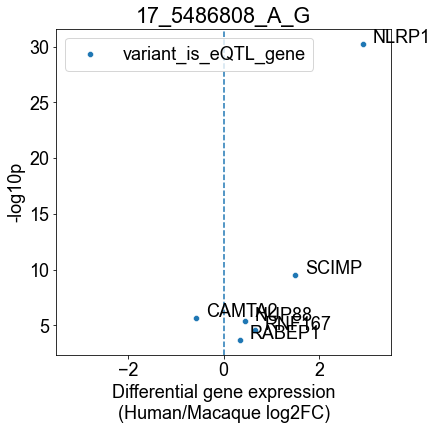

In [48]:
fig, ax = plt.subplots(figsize = (6,6))
x, y = "log2FoldChange", "-log10p"
data = rna.copy()

"""
# Draw the plot
sns.scatterplot(x = x, y = y, data=data, label = "variant__gene")

data = rna.loc[rna["SYMBOL"].isin(megabase)]

# Draw the plot
sns.scatterplot(x = x, y = y, data=data, label = "variant_is_500kb_gene")

ax.set(
title = ID,
xlabel = "differential gene expression (log2FC)"
)
"""

data = rna.loc[rna["SYMBOL"].isin(eqtl_genes)]
data[x] =data[x]*-1 
# Draw the plot
sns.scatterplot(x = x, y = y, data=data, label = "variant_is_eQTL_gene")

ax.set(
title = ID,
xlabel = "Differential gene expression\n(Human/Macaque log2FC)",
    xlim = (-3.5,3.5)
)
ax.axvline(0, ls = "--")
# Annotate eQTL label points 
for i, l in enumerate(data["SYMBOL"]):
    print(i, l, data[x].iloc[i])
    plt.annotate(l, (data[x].iloc[i]+0.2, data[y].iloc[i]+0.1) )
out = os.path.join(RE, "diff_exp_17_5486808_a_g.pdf")
plt.savefig(out, bbox_inches = "tight")
                   

In [46]:
pp.fonts()

('sans-serif', 'Arial', 18)

In [ ]:
out